In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import contextily as ctx
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score 
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor
from pyproj import Transformer
from haversine import haversine
from gurobipy import Model, GRB, quicksum, max_, min_, abs_
from scipy.spatial.distance import cdist
import os
os.makedirs('Figures',exist_ok = True)
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_rows', None)

df_EV = pd.read_excel("../AustinAreabyCity/filtered_file_EV charger station.xlsx")
df_grocery = pd.read_excel("../AustinAreabyCity/filtered_file_Grocery store.xlsx")
df_school = pd.read_excel("../AustinAreabyCity/filtered_file_school.xlsx")
df_mall = pd.read_excel("../AustinAreabyCity/filtered_file_shopping mall.xlsx")
df_cafe = pd.read_excel("../AustinAreabyCity/filtered_file_cafe.xlsx")
df_gas = pd.read_excel("../AustinAreabyCity/filtered_file_gas station.xlsx")
df_theater = pd.read_excel("../AustinAreabyCity/filtered_file_theater.xlsx")
df_intersection = pd.read_csv("../Transportation network/Austin_transport_intersections.csv",usecols=['lon','lat','street_count']).rename(columns={'lon':'Longitude','lat':'Latitude'})[['Latitude','Longitude','street_count']]
df_traffic = pd.read_csv("../Traffic/TxDOT AADT Annuals.csv", usecols=['y','x','AADT_2022']).rename(columns={'AADT_2022':'TrafficCount','y':'Latitude','x':'Longitude'})[['Latitude','Longitude','TrafficCount']]
df_intersection = pd.read_csv("../Transportation network/Austin_transport_intersections.csv",usecols=['lon','lat','street_count'])
df_intersection.columns = ['Longitude','Latitude','street_count']
df_intersection = df_intersection[['Latitude','Longitude','street_count']]



# for paper information only,get the total number of raw POIs (with and without hourly data)
df_EV = pd.read_csv("../AustinAreabyCity/rawfile/filtered_file_EV charger station.csv")
df_grocery = pd.read_csv("../AustinAreabyCity/rawfile/filtered_file_Grocery store.csv")
df_school = pd.read_csv("../AustinAreabyCity/rawfile/filtered_file_school.csv")
df_mall = pd.read_csv("../AustinAreabyCity/rawfile/filtered_file_shopping mall.csv")
df_cafe = pd.read_csv("../AustinAreabyCity/rawfile/filtered_file_cafe.csv")
df_gas = pd.read_csv("../AustinAreabyCity/rawfile/filtered_file_gas station.csv")
df_theater = pd.read_csv("../AustinAreabyCity/rawfile/filtered_file_theater.csv")
df_intersection = pd.read_csv("../Transportation network/Austin_transport_intersections.csv",usecols=['lon','lat','street_count']).rename(columns={'lon':'Longitude','lat':'Latitude'})[['Latitude','Longitude','street_count']]
df_traffic = pd.read_csv("../Traffic/TxDOT AADT Annuals.csv", usecols=['y','x','AADT_2022']).rename(columns={'AADT_2022':'TrafficCount','y':'Latitude','x':'Longitude'})[['Latitude','Longitude','TrafficCount']]
df_intersection = pd.read_csv("../Transportation network/Austin_transport_intersections.csv",usecols=['lon','lat','street_count'])
df_intersection.columns = ['Longitude','Latitude','street_count']
df_intersection = df_intersection[['Latitude','Longitude','street_count']]



In [5]:
min_long_1 = -98.18209496908116
max_long_1 = -97.37545599658112
min_lat_1 =30.0254665608216
max_lat_1 =30.637603376614

lat_lower_bound = min_lat_1 
lat_upper_bound = max_lat_1 
long_lower_bound = min_long_1 
long_upper_bound = max_long_1 

def filter_df(df, lat_lower, lat_upper, long_lower, long_upper):
    # Filter the DataFrame rows based on latitude and longitude bounds
    filtered_df = df[
        (df['Latitude'] >= lat_lower) & (df['Latitude'] <= lat_upper) &
        (df['Longitude'] >= long_lower) & (df['Longitude'] <= long_upper)
    ]
    
    # Return the filtered DataFrame
    return filtered_df.reset_index(drop = True)

df_EV = filter_df(df_EV, min_lat_1, max_lat_1, min_long_1, max_long_1)
df_traffic = filter_df(df_traffic, min_lat_1, max_lat_1, min_long_1, max_long_1)

In [6]:
points_set_1 = list(zip(df_EV['Latitude'], df_EV['Longitude']))   
points_set_2 = list(zip(df_grocery['Latitude'], df_grocery['Longitude'])) 
points_set_3 = list(zip(df_school['Latitude'], df_school['Longitude']))
points_set_4 = list(zip(df_mall['Latitude'], df_mall['Longitude']))    
points_set_5 = list(zip(df_cafe['Latitude'], df_cafe['Longitude']))
points_set_6 = list(zip(df_gas['Latitude'], df_gas['Longitude']))   
points_set_7 = list(zip(df_theater['Latitude'], df_theater['Longitude']))    
points_set_8 = list(zip(df_intersection['Latitude'],df_intersection['Longitude']))
points_set_9 = list(zip(df_traffic['Latitude'],df_traffic['Longitude']))

def filter_points(points, lat_lower, lat_upper, long_lower, long_upper):
    return [(lat, lon) for lat, lon in points if lat_lower <= lat <= lat_upper and long_lower <= lon <= long_upper]

# filtered_points_set_1 = filter_points(points_set_1, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_2 = filter_points(points_set_2, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_3 = filter_points(points_set_3, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_4 = filter_points(points_set_4, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_5 = filter_points(points_set_5, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_6 = filter_points(points_set_6, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_7 = filter_points(points_set_7, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_8 = filter_points(points_set_8, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)
filtered_points_set_9 = filter_points(points_set_9, lat_lower_bound, lat_upper_bound, long_lower_bound, long_upper_bound)

# Create a GeoDataFrame for both sets of points in WGS84 (lat/lon)
gdf_set_1 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in points_set_1], crs="EPSG:4326")
# gdf_set_1_radius = df_EV['Mean Coverage (miles)']
gdf_set_2 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_2], crs="EPSG:4326")
gdf_set_3 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_3], crs="EPSG:4326")
gdf_set_4 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_4], crs="EPSG:4326")
gdf_set_5 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_5], crs="EPSG:4326")
gdf_set_6 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_6], crs="EPSG:4326")
gdf_set_7 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_7], crs="EPSG:4326")
gdf_set_8 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_8], crs="EPSG:4326")
gdf_set_9 = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in filtered_points_set_9], crs="EPSG:4326")
# Reproject the GeoDataFrames to Web Mercator (EPSG:3857)
gdf_set_1 = gdf_set_1.to_crs(epsg=3857)
# gdf_set_1['geometry'] = gdf_set_1.geometry.buffer(1600*gdf_set_1_radius)
gdf_set_2 = gdf_set_2.to_crs(epsg=3857)
gdf_set_3 = gdf_set_3.to_crs(epsg=3857)
gdf_set_4 = gdf_set_4.to_crs(epsg=3857)
gdf_set_5 = gdf_set_5.to_crs(epsg=3857)
gdf_set_6 = gdf_set_6.to_crs(epsg=3857)
gdf_set_7 = gdf_set_7.to_crs(epsg=3857)
gdf_set_8 = gdf_set_8.to_crs(epsg=3857)
gdf_set_9 = gdf_set_9.to_crs(epsg=3857)

# df_EV_filtered = df_EV[['Latitude', 'Longitude', 'Charger Number', 'Max Power (kW)', 'Max Capacity (kWh)']]
df_EV_filtered = df_EV[['Latitude', 'Longitude', 'ChargerNumber']].assign( #assign adds new columns to dataframe
                        Longitude_EPSG3857 = gdf_set_1.geometry.x,
                        Latitude_EPSG3857 = gdf_set_1.geometry.y).dropna()
df_traffic = df_traffic.assign(
            Longitude_EPSG3857 = gdf_set_1.geometry.x,
            Latitude_EPSG3857 = gdf_set_1.geometry.y).dropna()

In [7]:
df_traffic.columns

Index(['Latitude', 'Longitude', 'TrafficCount', 'Longitude_EPSG3857',
       'Latitude_EPSG3857'],
      dtype='object')

In [8]:
# Approximate lat/lon extent for DFW (latitude and longitude)
north, south, east, west = lat_upper_bound, lat_lower_bound, long_upper_bound, long_lower_bound
# Convert these lat/lon values to EPSG:3857 (meters) using GeoPandas
# Create a GeoDataFrame with the bounding box corners
df_extent = gpd.GeoDataFrame(geometry=[Point(west, south), Point(east, north)], crs="EPSG:4326")
# Reproject to Web Mercator (EPSG:3857)
df_extent = df_extent.to_crs(epsg = 3857)

# Get the bounds in meters for the DFW area
minx, miny = df_extent.total_bounds[0], df_extent.total_bounds[1]
maxx, maxy = df_extent.total_bounds[2], df_extent.total_bounds[3]

# Function to generate grid cells, and give name of grid_cells_ID
def create_grid(minx, miny, maxx, maxy, grid_size):
    x_vals = np.arange(minx, maxx, grid_size)
    y_vals = np.arange(miny, maxy, grid_size)

    grid_cells = [Polygon([(x, y), (x + grid_size, y), (x + grid_size, y + grid_size), (x, y + grid_size)]) for x in x_vals for y in y_vals]
    return grid_cells, x_vals, y_vals

def calculate_distance_and_radius(x_min, x_max, y_min, y_max, point):
    # center of the grid cell
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    # Calculate the radius as the width of the grid cell
    radius = x_max - x_min
    # Calculate the Euclidean distance from the point to the center of the circle
    distance = sqrt((point.x - center_x) ** 2 + (point.y - center_y) ** 2)
    return distance, radius

def Plot_Map(gdf_grid,gdf_set_1,gdf_set_2,gdf_set_3,gdf_set_4,gdf_set_5,gdf_set_6,gdf_set_7,gdf_set_8,gdf_set_9,minx,maxx,miny,maxy):
    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 12))
    # Plot the grid
    gdf_grid.boundary.plot(ax=ax, color="gray", linewidth=1.5, alpha=0.8)

    # Plot both sets of points in the new coordinate system (meters)

    # gdf_set_1.plot(ax=ax, color = 'blue', label='EV Charger', marker='o', markersize=30)
    # # gdf_set_1.plot(ax=ax, edgecolor='blue', facecolor='none', marker='o', markersize=30, alpha=0.72)
    # gdf_set_2.plot(ax=ax, color='red', label='Grocery', marker='x', markersize=36)
    # gdf_set_3.plot(ax=ax, color='orange', label='School', marker='^', markersize=45) ############
    # gdf_set_4.plot(ax=ax, color='cyan', label='Mall', marker='+', markersize=72)
    # gdf_set_5.plot(ax=ax, color='yellow', label='Cafe', marker='v', markersize=45)
    # gdf_set_6.plot(ax=ax, color='magenta', facecolor='none', label='Gas station', marker='s', markersize=45)
    # gdf_set_7.plot(ax=ax, color='green', label='Theater',  marker='*', markersize=90)
    # gdf_set_8.plot(ax=ax, color='grey', facecolor='none', label='Road Intersection', marker='o', alpha=0.3, markersize=5)
    # gdf_set_9.plot(ax=ax, color='purple', label='Traffic Counts',  marker='d', alpha=0.5, markersize=25)
    gdf_set_1.plot(ax=ax, color = 'blue', label='EV Charger', marker='o', markersize=30)
    # gdf_set_1.plot(ax=ax, edgecolor='blue', facecolor='none', marker='o', markersize=30, alpha=0.72)
    gdf_set_2.plot(ax=ax, color='red', label='Retail', marker='x', markersize=36)
    gdf_set_3.plot(ax=ax, color='orange', label='Education', marker='^', markersize=45) ############
    gdf_set_4.plot(ax=ax, color='cyan', label='Mall', marker='+', markersize=72)
    gdf_set_5.plot(ax=ax, color='yellow', label='Restaurant', marker='v', markersize=45)
    gdf_set_6.plot(ax=ax, color='magenta', facecolor='none', label='Service', marker='s', markersize=45)
    gdf_set_7.plot(ax=ax, color='green', label='Entertainment',  marker='*', markersize=90)
    gdf_set_8.plot(ax=ax, color='grey', facecolor='none', label='Road Intersection', marker='o', alpha=0.3, markersize=5)
    gdf_set_9.plot(ax=ax, color='purple', label='Traffic',  marker='d', alpha=0.5, markersize=25)
    # Set the bounding box for the DFW area (in meters)
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])
    # Add a basemap (tile) to give the background using OpenStreetMap (EPSG:3857)
    ctx.add_basemap(ax, crs=gdf_set_1.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    # ax.set_title("Location Points Map in Austin Area", fontsize=18, fontweight='bold')
    plt.xlabel("Longitude (meter)",fontsize=18)
    plt.ylabel("Latitude (meter)",fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize = 18)
    plt.legend(fontsize = 18,loc='lower right')
    # plt.savefig('Figures\LocationPointsMap.pdf',bbox_inches='tight')
    plt.savefig('Figures\LocationPointsMap.png',bbox_inches='tight')
    plt.show()


def filter_points_grid_cell(df,x_min,x_max,y_min,y_max,column = None):
    if column is not None:
        return df[( df['Longitude_EPSG3857']>=x_min) & 
                    (df['Longitude_EPSG3857']<x_max) & 
                    (df['Latitude_EPSG3857']>=y_min) &
                    (df['Latitude_EPSG3857']< y_max)][column].sum()
    else:
        # count = 0
        # for _,row in df.iterrows():
        #     point = row['geometry']
        #     distance, radius = calculate_distance_and_radius(x_min, x_max, y_min, y_max, point) # this only considers the circle, not rectangular
        #     if distance <= radius:
        #         count+=1
        # return count
        return len(df[
                    (df.geometry.x>=x_min) & 
                    (df.geometry.x<x_max)  & 
                    (df.geometry.y>=y_min) &
                    (df.geometry.y< y_max)])



In [40]:
columns_all = ['EV', 'Grocery', 'School', 'Mall', 'Cafe', 'Gas', 'Theater', 'TrafficCount','Intersection']
columns_poi = ['Grocery', 'School', 'Mall', 'Cafe', 'Gas', 'Theater','TrafficCount','Intersection']
df_origin = pd.DataFrame(columns=columns_all)

data_to_save = {
    "correlation_matrices":{},
    "y_xgb_final_pred":{}
}
# Generate a grid
# grid_sizes=np.arange(500,20000,500)
grid_sizes=  np.arange(500,15600,100) #[6300]#np.arange(500,15600,100)

for g in grid_sizes:
    grid_size = g  # 400 meters ##################################################################
    # def data_prepare(grid_size):
    grid_cells, x_vals, y_vals = create_grid(minx, miny, maxx, maxy, grid_size)
    gdf_grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:3857")
    # gdf_grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:4326")
    # Plot_Map(gdf_grid,gdf_set_1,gdf_set_2,gdf_set_3,gdf_set_4,gdf_set_5,gdf_set_6,gdf_set_7,gdf_set_8,gdf_set_9,minx,maxx,miny,maxy)
    results=[]
    for polygon in grid_cells:
        x_min, y_min, x_max, y_max = polygon.bounds
        ev_number = filter_points_grid_cell(df_EV_filtered, x_min,x_max,y_min,y_max,column='ChargerNumber')
        grocery_number = filter_points_grid_cell(gdf_set_2,x_min,x_max,y_min,y_max,column=None)
        school_number = filter_points_grid_cell(gdf_set_3,x_min,x_max,y_min,y_max,column=None)
        mall_number = filter_points_grid_cell(gdf_set_4,x_min,x_max,y_min,y_max,column=None)
        cafe_number = filter_points_grid_cell(gdf_set_5,x_min,x_max,y_min,y_max,column=None)
        gas_number = filter_points_grid_cell(gdf_set_6,x_min,x_max,y_min,y_max,column=None)
        theater_number = filter_points_grid_cell(gdf_set_7,x_min,x_max,y_min,y_max,column=None)
        traffic_count = filter_points_grid_cell(df_traffic, x_min,x_max,y_min,y_max,column='TrafficCount')
        intersection_count = filter_points_grid_cell(gdf_set_8,x_min,x_max,y_min,y_max,column=None)
        results.append({
            'EV': ev_number,
            'Grocery': grocery_number,
            'School': school_number,
            'Mall': mall_number, 
            'Cafe': cafe_number, 
            'Gas': gas_number, 
            'Theater': theater_number,
            'TrafficCount': traffic_count,
            'Intersection': intersection_count})

    df_origin = pd.DataFrame(results)
    
    
    # C1:0 EV, 0 POI (training)
    # C2:With EV, With POI (training)
    # C3:0 EV, with POI (prediction)
    # C4:With EV, 0 POI (NA data, eleminate)
    
    #original dataframe
    df_origin_copy = df_origin.copy()
    
    df_nonZero = df_origin_copy[df_origin_copy['EV'] != 0] #C2 and C4
    df_0 = df_origin_copy[(df_origin_copy[columns_all] == 0).all(axis=1)] #C1
    df_1 = pd.concat([df_nonZero, df_0], axis=0)
    df_NA = df_origin_copy[(df_origin_copy['EV'] != 0) & (df_origin_copy[columns_poi] == 0).all(axis=1)] #C4
    df_train = df_1.drop(df_NA.index) #C1 and C2
    
    ev_zero = df_origin_copy['EV'] == 0
    nonzero_columns = df_origin_copy[columns_poi].any(axis=1)
    
    df_predict = df_origin_copy[ev_zero & nonzero_columns]
    df_train = df_train.astype(np.float32)
    df_predict = df_predict.astype(np.float32)
    
    features_predict = df_predict[columns_poi].values
    df_train['EV_Class'] = df_train['EV'].apply(lambda x: 'Yes' if x > 0 else 'No')
    
    features_smote = df_train[columns_all].values
    target_smote = df_train['EV_Class'].values
    
    # X_resampled_1, y_resampled_1 = SMOTE().fit_resample(features_smote, target_smote)
    X_resampled_1, y_resampled_1 = features_smote, target_smote
    np.random.shuffle(X_resampled_1)
    
    X_train_resampled = X_resampled_1[:, 1:]
    y_train_resampled = X_resampled_1[:, 0]
    eda_df = pd.DataFrame(X_train_resampled, columns=columns_poi)
    eda_df['EV'] = y_train_resampled
    # Correlation matrix
    correlation_matrix = eda_df.corr()
    data_to_save["correlation_matrices"][grid_size] = correlation_matrix
    X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size = 0.3, random_state = 0)
    xgb = XGBRegressor(n_estimators = 500, max_depth = 8, eta = 0.01, subsample = 0.7, colsample_bytree = 0.8)
    xgb.fit(X_train_resampled, y_train_resampled)    
    data_to_save["y_xgb_final_pred"][grid_size] = xgb.predict(features_predict)
import pickle
with open('correlation_matrices_V8raw_square_PredictionAccuracy.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [41]:
data_to_save

{'correlation_matrices': {500:                Grocery    School      Mall      Cafe       Gas   Theater  \
  Grocery       1.000000  0.462074  0.275252  0.473542  0.348874  0.066357   
  School        0.462074  1.000000  0.062377  0.282455  0.399631  0.157594   
  Mall          0.275252  0.062377  1.000000  0.276206  0.134680  0.311123   
  Cafe          0.473542  0.282455  0.276206  1.000000  0.388565  0.284341   
  Gas           0.348874  0.399631  0.134680  0.388565  1.000000  0.133520   
  Theater       0.066357  0.157594  0.311123  0.284341  0.133520  1.000000   
  TrafficCount  0.127565  0.080200  0.169103  0.251606  0.127490  0.336149   
  Intersection  0.172933  0.140609  0.189428  0.324313  0.203677  0.272390   
  EV            0.239290  0.100865  0.426698  0.328170  0.176315  0.335357   
  
                TrafficCount  Intersection        EV  
  Grocery           0.127565      0.172933  0.239290  
  School            0.080200      0.140609  0.100865  
  Mall              0.1

In [56]:
# # load correlation_matrices_V5_square_PredictionAccuracy.pkl
# import pickle
# with open('correlation_matrices_V5_square_PredictionAccuracy.pkl', 'rb') as f:
#     data_to_save = pickle.load(f)

In [45]:
import pickle
with open('correlation_matrices_V7raw_square_PredictionAccuracy.pkl','rb') as f:
# with open('correlation_matrices_V5_square_PredictionAccuracy_alldata.pkl','rb') as f:
    data_to_save = pickle.load(f)
data_to_save["correlation_matrices"][6300]

# Plot_Map(gdf_grid,gdf_set_1,gdf_set_2,gdf_set_3,gdf_set_4,gdf_set_5,gdf_set_6,gdf_set_7,gdf_set_8,gdf_set_9,minx,maxx,miny,maxy)

,Grocery,School,Mall,Cafe,Gas,Theater,TrafficCount,Intersection,EV
Grocery,1.000000,0.559738,0.342878,0.739837,0.543165,0.370725,0.294369,0.377336,0.251580
School,0.559738,1.000000,0.406485,0.763099,0.766302,0.313993,0.090561,0.051491,0.117273
Mall,0.342878,0.406485,1.000000,0.474883,0.570959,0.487639,0.398510,0.389231,0.417215
Cafe,0.739837,0.763099,0.474883,1.000000,0.816551,0.665458,0.370258,0.321162,0.382043
Gas,0.543165,0.766302,0.570959,0.816551,1.000000,0.566800,0.239125,0.194677,0.267977
Theater,0.370725,0.313993,0.487639,0.665458,0.566800,1.000000,0.663987,0.519445,0.725355
TrafficCount,0.294369,0.090561,0.398510,0.370258,0.239125,0.663987,1.000000,0.535247,0.924447
Intersection,0.377336,0.051491,0.389231,0.321162,0.194677,0.519445,0.535247,1.000000,0.509437
EV,0.251580,0.117273,0.417215,0.382043,0.267977,0.725355,0.924447,0.509437,1.000000


Grid Size: 500, Sum of correlations for 'EV': 2.7231293615444327, y predict sum: 34172.11328125
Grid Size: 600, Sum of correlations for 'EV': 2.567205074650839, y predict sum: 16013.0625
Grid Size: 700, Sum of correlations for 'EV': 2.688907504760374, y predict sum: 14191.3740234375
Grid Size: 800, Sum of correlations for 'EV': 2.852116893232886, y predict sum: 7157.14892578125
Grid Size: 900, Sum of correlations for 'EV': 3.0048384347786348, y predict sum: 7229.015625
Grid Size: 1000, Sum of correlations for 'EV': 3.203384942351075, y predict sum: 4924.59375
Grid Size: 1100, Sum of correlations for 'EV': 2.959359225849299, y predict sum: 5059.80029296875
Grid Size: 1200, Sum of correlations for 'EV': 3.216289372102111, y predict sum: 5049.267578125
Grid Size: 1300, Sum of correlations for 'EV': 3.1515355737321533, y predict sum: 4318.013671875
Grid Size: 1400, Sum of correlations for 'EV': 3.232617135944847, y predict sum: 4679.95751953125
Grid Size: 1500, Sum of correlations for 'EV'

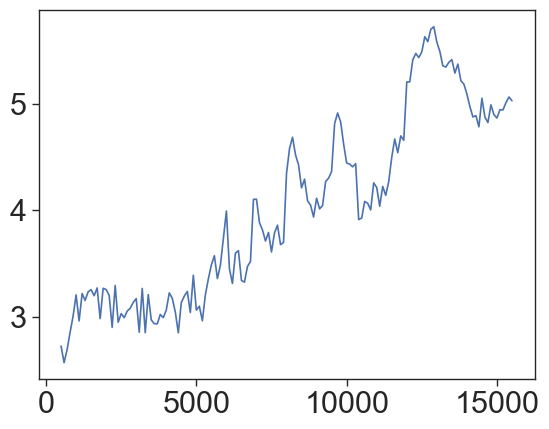

In [46]:
# correlation_matrices[2000]['EV'].drop('EV').sum()
x={}
for a,b in data_to_save["correlation_matrices"].items():
    print(f"Grid Size: {a}, Sum of correlations for 'EV': {b['EV'].drop('EV').sum()}, y predict sum: {data_to_save['y_xgb_final_pred'][a].sum()}")
    x[a] = b['EV'].drop('EV').sum()
    
plt.plot(list(x.keys()),list(x.values()))
plt.show()

In [109]:
sss = {k/1000: k for k, v in data_to_save['y_xgb_final_pred'].items()}
sss


{0.5: 500,
 0.6: 600,
 0.7: 700,
 0.8: 800,
 0.9: 900,
 1.0: 1000,
 1.1: 1100,
 1.2: 1200,
 1.3: 1300,
 1.4: 1400,
 1.5: 1500,
 1.6: 1600,
 1.7: 1700,
 1.8: 1800,
 1.9: 1900,
 2.0: 2000,
 2.1: 2100,
 2.2: 2200,
 2.3: 2300,
 2.4: 2400,
 2.5: 2500,
 2.6: 2600,
 2.7: 2700,
 2.8: 2800,
 2.9: 2900,
 3.0: 3000,
 3.1: 3100,
 3.2: 3200,
 3.3: 3300,
 3.4: 3400,
 3.5: 3500,
 3.6: 3600,
 3.7: 3700,
 3.8: 3800,
 3.9: 3900,
 4.0: 4000,
 4.1: 4100,
 4.2: 4200,
 4.3: 4300,
 4.4: 4400,
 4.5: 4500,
 4.6: 4600,
 4.7: 4700,
 4.8: 4800,
 4.9: 4900,
 5.0: 5000,
 5.1: 5100,
 5.2: 5200,
 5.3: 5300,
 5.4: 5400,
 5.5: 5500,
 5.6: 5600,
 5.7: 5700,
 5.8: 5800,
 5.9: 5900,
 6.0: 6000,
 6.1: 6100,
 6.2: 6200,
 6.3: 6300,
 6.4: 6400,
 6.5: 6500,
 6.6: 6600,
 6.7: 6700,
 6.8: 6800,
 6.9: 6900,
 7.0: 7000,
 7.1: 7100,
 7.2: 7200,
 7.3: 7300,
 7.4: 7400,
 7.5: 7500,
 7.6: 7600,
 7.7: 7700,
 7.8: 7800,
 7.9: 7900,
 8.0: 8000,
 8.1: 8100,
 8.2: 8200,
 8.3: 8300,
 8.4: 8400,
 8.5: 8500,
 8.6: 8600,
 8.7: 8700,
 8.8: 880

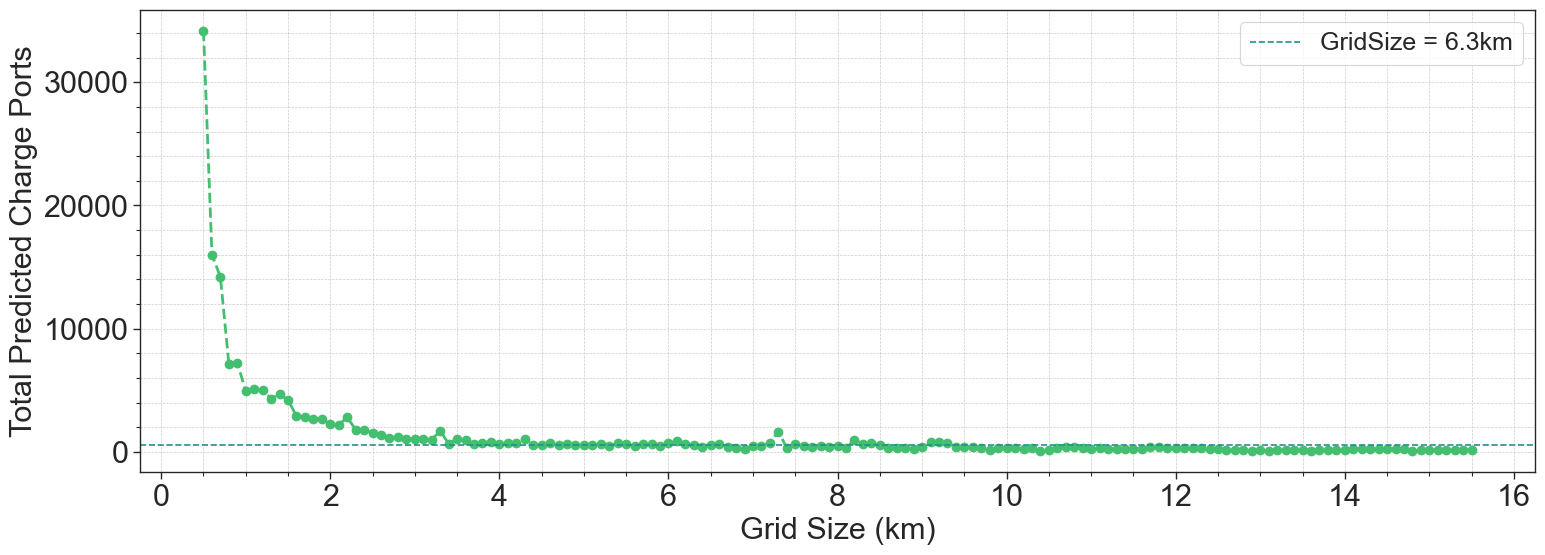

In [55]:
import pickle
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.titlesize'] = 27
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22

with open('correlation_matrices_V7raw_square_PredictionAccuracy.pkl','rb') as f:
# with open('correlation_matrices_V5_square_PredictionAccuracy_alldata.pkl','rb') as f:
    data_to_save = pickle.load(f)
sum_total = [np.sum(v) for v in data_to_save['y_xgb_final_pred'].values()]
color = cm.viridis(0.7)
fig,ax = plt.subplots(figsize=(18, 6)) #plt.figure(figsize=(18,6))
# ax.set_ylim(0, 10000)

data_to_save['y_xgb_final_pred'] = {key / 1000: value for key, value in data_to_save['y_xgb_final_pred'].items()}


plt.plot(
    list(data_to_save['y_xgb_final_pred'].keys()),
    sum_total,
    marker = 'o',linestyle = '--', linewidth = 2, markersize = 6, color = color
)
plt.axhline(sum(data_to_save['y_xgb_final_pred'][6.3]),linestyle = '--',color=cm.viridis(0.5), label = 'GridSize = 6.3km')
plt.minorticks_on()
plt.grid(which = 'minor',linestyle ='--',linewidth = '0.5')
plt.grid(which = 'major',linestyle ='--',linewidth = '0.5')
plt.legend(fontsize = 18)
plt.xlabel('Grid Size (km)',fontsize = 22)
plt.ylabel('Total Predicted Charge Ports',fontsize = 22)

plt.savefig('Figures/Sensitivity of Charge Ports.pdf',format = 'pdf')
plt.show()


In [15]:
sum(data_to_save['y_xgb_final_pred'][6300])

296.21322697401047

In [30]:
# correlation_matrices[2000]['EV'].drop('EV').sum()
x=[]
for a,b in data_to_save['correlation_matrices'].items():
    # print(f"Grid Size: {a}, Sum of correlations for 'EV': {b['EV'].drop('EV').mean()}")
    # x[a] = b['EV'].drop('EV').mean()
    
    x.append(b['EV'].drop('EV'))
    
# plt.plot(list(x.keys()),list(x.values()))
# plt.show()
combined_df = pd.concat({
    key/1000: pd.DataFrame(b['EV']).drop('EV') for key, b in data_to_save['correlation_matrices'].items()},axis=1)
combined_df.columns = [f"{key}km" for key, col in combined_df.columns]
combined_df

,0.5km,0.6km,0.7km,0.8km,0.9km,1.0km,1.1km,1.2km,1.3km,1.4km,...,14.6km,14.7km,14.8km,14.9km,15.0km,15.1km,15.2km,15.3km,15.4km,15.5km
Grocery,0.239290,0.246787,0.217055,0.224819,0.258326,0.287168,0.232650,0.352932,0.296718,0.242453,...,0.349471,0.357623,0.410877,0.421635,0.428578,0.449208,0.457635,0.476157,0.523977,0.539913
School,0.100865,0.056738,0.033667,0.083160,0.105426,0.172071,0.149496,0.156663,0.125922,0.137033,...,0.176508,0.163634,0.197779,0.155383,0.141666,0.160221,0.148025,0.175589,0.223616,0.197180
Mall,0.426698,0.380173,0.343544,0.397924,0.388093,0.461088,0.365091,0.403987,0.510389,0.444753,...,0.671338,0.680468,0.687778,0.684125,0.658284,0.689541,0.681415,0.697281,0.681587,0.654746
Cafe,0.328170,0.289546,0.357307,0.396726,0.322014,0.401781,0.320515,0.393675,0.356473,0.333919,...,0.594539,0.590857,0.610414,0.600484,0.595075,0.593147,0.582654,0.559013,0.568224,0.581443
Gas,0.176315,0.192867,0.126158,0.220969,0.226942,0.234991,0.176332,0.205862,0.214897,0.133278,...,0.410335,0.371064,0.428201,0.400502,0.388041,0.394220,0.422127,0.436177,0.465670,0.463844
Theater,0.335357,0.293316,0.446819,0.388107,0.496871,0.428364,0.504386,0.511138,0.434948,0.636600,...,0.828609,0.812461,0.815003,0.799146,0.805183,0.801602,0.798046,0.806341,0.750477,0.758887
TrafficCount,0.627129,0.630832,0.679529,0.676287,0.707912,0.684838,0.737217,0.725816,0.746972,0.828595,...,0.977865,0.978042,0.982192,0.974678,0.978380,0.977181,0.970918,0.973535,0.980815,0.983441
Intersection,0.489307,0.476946,0.484829,0.464125,0.499255,0.533084,0.473672,0.466217,0.465217,0.475986,...,0.864851,0.867703,0.855904,0.860002,0.869371,0.877212,0.879800,0.884884,0.867667,0.847352


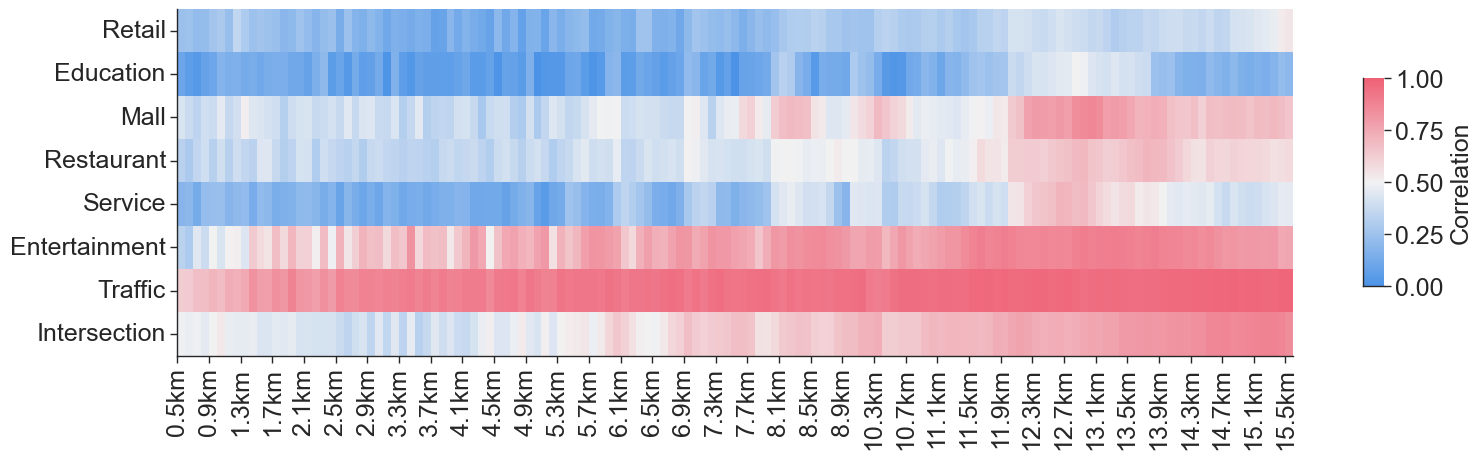

In [54]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------------------
# 1. Define a style close to Nature's style
# --------------------------------------------------------------------
# You can use a context to adjust global figure parameters.
# 'paper' context is typically used for journal publications.
sns.set_theme(context='paper', style='ticks')

# If you want to keep Times New Roman for everything, you can do:
mpl.rcParams['font.family'] = 'Arial'
# Otherwise, for a more typical Nature figure style, you might use:
# mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['axes.titlesize'] = 27
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

mild_bright_cmap = sns.diverging_palette(
    h_neg=610,   # hue for negative side (blue-ish)
    h_pos=6,    # hue for positive side  (red/orange-ish)
    s=80,        # saturation: higher = more vivid color
    l=60,        # lightness: higher = brighter/pastel
    n=512,       # number of discrete colors in the palette
    center="light",  # ensures the midpoint is a lighter color
    as_cmap=True
)

# --------------------------------------------------------------------
# 2. Filter your DataFrame as before
# --------------------------------------------------------------------
# filtered_combined_df = combined_df.loc[:, [f"{key}" for i, key in enumerate(combined_df.columns) 
#                                            if float(key.split('km')[0]) <= 8 and i % 1 == 0]]
filtered_combined_df = combined_df.loc[:, [key for i, key in enumerate(combined_df.columns) 
                                           if float(key[0]) <= 8 and i % 1 == 0]]
row_rename_mapping = {
    'Grocery': 'Retail',
    'School': 'Education',
    'Mall': 'Mall',
    'Cafe': 'Restaurant',
    'Gas': 'Service',
    'Theater': 'Entertainment',
    'TrafficCount': 'Traffic',
}
filtered_combined_df = filtered_combined_df.rename(index=row_rename_mapping)
# --------------------------------------------------------------------
# filter the DataFrame to start from 1.0km
filtered_combined_df = filtered_combined_df.loc[:, '0.5km':]
# --------------------------------------------------------------------
# 3. Create the figure and heatmap
# --------------------------------------------------------------------
# Adjust figure size for a single or double column in Nature.
# For single column (~3.5 in wide), or double column (~7.2 in wide).
plt.figure(figsize=(18, 4.5))  # Example for a 2-column figure

ax = sns.heatmap(
    filtered_combined_df, 
    cmap=mild_bright_cmap,
    vmin=0, vmax=1,
    fmt=".2f", 
    cbar=True, 
    annot=False,
    cbar_kws={"shrink": 0.6, "aspect": 10, "label": "Correlation"}  # Adjust color bar size
)


# Title: Keep it concise; use a font size around 12–14 for titles
# plt.title("POI-Based Spatial Correlation of EV Charging Demand", fontsize=27)

# Adjust tick parameters if needed
# make the tick every 2 grid cells
xticks = np.arange(0, len(filtered_combined_df.columns), step=4)
ax.set_xticks(xticks)
ax.set_xticklabels(filtered_combined_df.columns[xticks], rotation=90)  # Rotate for readability

# ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.tick_params(axis='y', rotation=0)

# Remove top and right spines for a cleaner look
sns.despine()

# --------------------------------------------------------------------
# 4. Save the figure
# --------------------------------------------------------------------
plt.savefig(
    "Figures/Gridsizesweep1.pdf", 
    format='pdf', 
    bbox_inches='tight', 
    dpi=300
)

plt.show()


In [30]:
filtered_combined_df.head()

,0.5km,0.6km,0.7km,0.8km,0.9km,1.0km,1.1km,1.2km,1.3km,1.4km,...,16.9km,17.0km,17.1km,17.2km,17.3km,17.4km,17.5km,17.6km,17.7km,17.8km
Grocery,0.264293,0.196169,0.224107,0.174791,0.275947,0.284577,0.272457,0.371435,0.305608,0.200264,...,0.508360,0.510326,0.511555,0.558045,0.546114,0.553463,0.564057,0.568703,0.555724,0.567102
School,NaN,NaN,NaN,NaN,-0.007933,0.021850,NaN,0.028162,0.028227,-0.014149,...,0.481116,0.535492,0.537819,0.567809,0.403858,0.406198,0.404620,0.406070,0.403899,0.403583
Mall,0.450398,0.398009,0.369061,0.347245,0.434432,0.441400,0.366145,0.426825,0.551116,0.435892,...,0.899305,0.924931,0.920044,0.922732,0.926551,0.931037,0.927889,0.924194,0.941273,0.940043
Cafe,0.303637,0.269879,0.335964,0.399663,0.371582,0.465105,0.321102,0.422945,0.341703,0.312132,...,0.562014,0.605263,0.612097,0.649209,0.652247,0.668551,0.681647,0.682217,0.679212,0.693408
Gas,0.169386,0.181515,0.121828,0.207471,0.242520,0.236245,0.161492,0.190102,0.226120,0.107952,...,0.702370,0.753070,0.747354,0.777560,0.783506,0.783565,0.790103,0.777369,0.770773,0.732333


In [75]:
# [f"{key}_m" for i, (key,_) in enumerate(combined_df.columns) if key<=10000 and i%2==0]
for i, key in enumerate(combined_df.columns):
    print(f"i={i},key={key}")

i=0,key=500_m
i=1,key=600_m
i=2,key=700_m
i=3,key=800_m
i=4,key=900_m
i=5,key=1000_m
i=6,key=1100_m
i=7,key=1200_m
i=8,key=1300_m
i=9,key=1400_m
i=10,key=1500_m
i=11,key=1600_m
i=12,key=1700_m
i=13,key=1800_m
i=14,key=1900_m
i=15,key=2000_m
i=16,key=2100_m
i=17,key=2200_m
i=18,key=2300_m
i=19,key=2400_m
i=20,key=2500_m
i=21,key=2600_m
i=22,key=2700_m
i=23,key=2800_m
i=24,key=2900_m
i=25,key=3000_m
i=26,key=3100_m
i=27,key=3200_m
i=28,key=3300_m
i=29,key=3400_m
i=30,key=3500_m
i=31,key=3600_m
i=32,key=3700_m
i=33,key=3800_m
i=34,key=3900_m
i=35,key=4000_m
i=36,key=4100_m
i=37,key=4200_m
i=38,key=4300_m
i=39,key=4400_m
i=40,key=4500_m
i=41,key=4600_m
i=42,key=4700_m
i=43,key=4800_m
i=44,key=4900_m
i=45,key=5000_m
i=46,key=5100_m
i=47,key=5200_m
i=48,key=5300_m
i=49,key=5400_m
i=50,key=5500_m
i=51,key=5600_m
i=52,key=5700_m
i=53,key=5800_m
i=54,key=5900_m
i=55,key=6000_m
i=56,key=6100_m
i=57,key=6200_m
i=58,key=6300_m
i=59,key=6400_m
i=60,key=6500_m
i=61,key=6600_m
i=62,key=6700_m
i=63,ke

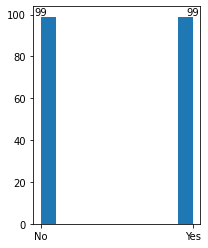

In [6]:
plt.figure(figsize=(3, 4))
plt.hist(y_resampled_1)
plt.xticks([0, 1], ['No', 'Yes'])
counts = np.bincount(np.where(y_resampled_1 == 'Yes', 1, 0))
for index, count in enumerate(counts):
    plt.text(index, count, str(count), ha='center', va='bottom')

In [33]:
X_train_resampled

array([[2.700000e+01, 9.000000e+00, 5.700000e+01, 9.600000e+01,
        2.300000e+01, 5.500000e+01, 2.994182e+06, 5.632000e+03],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 4.000000e+00,
        0.000000e+00, 0.000000e+00, 3.936600e+04, 5.250000e+02],
       [2.600000e+01, 8.000000e+00, 4.000000e+00, 6.300000e+01,
        7.000000e+00, 2.000000e+00, 3.679390e+05, 1.966000e+03],
       [7.700000e+01, 1.100000e+01, 1.400000e+01, 9.300000e+01,
        1.200000e+01, 2.000000e+00, 8.859160e+05, 2.977000e+03],
       [0.000000e+00, 3.000000e+00, 3.000000e+00, 1.000000e+00,
        5.000000e+00, 4.000000e+00, 2.226700e+04, 8.360000e+02],
       [2.500000e+01, 7.000000e+00, 2.100000e+01, 5.300000e+01,
        1.300000e+01, 1.300000e+01, 6.954000e+05, 2.502000e+03],
       [7.400000e+01, 2.100000e+01, 5.900000e+01, 1.380000e+02,
        2.500000e+01, 2.200000e+01, 2.802688e+06, 3.974000e+03],
       [1.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


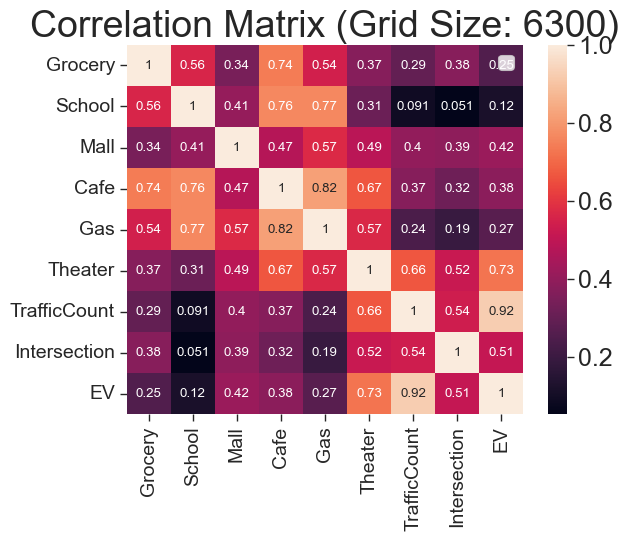

Length of training dataset:  63
Length of testing dataset:  132
Length of ALL zero dataset:  4
Length of incorrect data removed:  0



In [35]:
eda_df = pd.DataFrame(X_train_resampled, columns=columns_poi)
eda_df['EV'] = y_train_resampled

# Correlation matrix
correlation_matrix = eda_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title(f'Correlation Matrix (Grid Size: {grid_size})')

plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.savefig(f'Figures\correlation_matrix.pdf',bbox_inches='tight')
plt.show()

print("Length of training dataset: ",  len(df_train))
print("Length of testing dataset: ",  len(df_origin_copy) - len(df_train))
print("Length of ALL zero dataset: ",  len(df_0))
print("Length of incorrect data removed: ",  len(df_NA))
print()